# 3.2.3 When the subject starts changing its feedback confidence

Previous simulations have shown how the noise affecting the biomarker affected the training of a subject depending on its expectations. However, they also assumed that those expectations were fixed and did **not** change accross the training. We believe this oversimplification glosses over one of the major mechanics of BCI training : the subject changing level of confidence about the reliability of the provided feedback accross the trials. 

The next simulations featured the same **M1** model as previous simulations (3.2.1 and 3.2.2) with a slight change : the feedback mapping (relating cognitive state and observation) is made dynamic and the subject continuously updates its model of it. 

A new parameter becomes relevant then : the subject confidence in its feedback *model* (warning : different from the subject confidence in the *feedback*, which was previously represented as a fixed parameter $\sigma_{model}$). This parameter, called $k1_a$, describes how much new evidence is required by the subject to change its prior about feedback mapping. In other words, it formalizes how *resilient* the observation model of the subject is to the uother sources of uncertainties (for now, the unknown transition rule and its own model confidence parameter $k1_b$).

In [1]:
# Make basic package imports
import numpy as np
import statistics as stat
import scipy.stats as scistats
import math,sys,os
import pickle 
import matplotlib.pyplot as plt

# Import actynf and the functions to help us plot the results
import actynf
from tools import simulate_and_save,extract_training_data # Saving and loading simulation outputs
from tools import dist_kl_dir # A tool to qualify subject learning
from tools import pointcloud_mean,clever_running_mean # Plot the mean + std of several points

from tools_trial_plots import plot_one_trial,plot_training_curve # Plotting individual trials / subject performances accross several trials
from m1_model import neurofeedback_training # The Active Inference model we use

SAVING_FOLDER = os.path.join("..","..","simulation_outputs","paper1","3.2.3")
FIGURES_FOLDER = os.path.join("figures","3.2.3")

print("Results will be saved to " + SAVING_FOLDER + " (relative to this file)")

# Functions defining the model and plotting the results !

# Here, we set the learn_a parameter to True and k1a becomes a parameter !
# Please note that we also set epsilon_a to 0.01 instead of 0, in effect allowing
# our agent to learn mappings outside of the pre-training discretized normal distribution.
def run_and_save_model(savepath,
        true_feedback_std,belief_feedback_std,k1a,
        Nsubj,Ntrials,
        overwrite=False):
    """
    Run a simulation of model m1 using the following parameters : 
    - savepath : where to store simulation outputs
    - true_feedback_std : wanted sigma_process value
    - belief_feedback_std : wanted sigma_model value for the feedback
    - Nsubj : subjects simulated for the simulations
    - Ntrials : how many trials simulated per subject (duration of the training)
    - overwrite : run simulations even if there exist results already ?
    """
    learn_a = True # In this simulation, the subjects will question their observation and 
                   # transition mappings simultaneously !

    T = 10
    Th = 2
    feedback_resolution = 5 # No
    subj_cognitive_resolution = 5 # Ns (model)
    true_cognitive_resolution = 5 # Ns (process)

    k1b = 0.01   # Initial action mapping weight
    epsilon_b = 0.01

         # Initial feedback mapping weight (model)
    epsilon_a = 0.01   # Added uniform distribution weight added
        # a0 is defined as = norm(epsilon_a* ones + gaussian_prior)*k1a

    k1d = 1.0   # Initial starting state mapping weight (model)
    epsilon_d = 1.0  # Added uniform distribution weight added
        # d0 is defined as = norm(epsilon_d* ones + [1,1,0,0,0])*k1d   [for Ns=5]
    
    neutral_action_prop = 0.2 # 20% of the actions have no effect on the subject cognitive state

    pRest = 0.5   # Without any increasing action, there is a pRest chance that the cognitive state will decrease spontaneously
    pEffect  = 0.99   # An adequate action will increase the subject mental state with a probability pEffect

    action_selection_inverse_temp = 32.0 # How much noise in the selection of actions after EFE calculation
    
    net = neurofeedback_training(T,Th,  # Trial duration + temporal horizon
            subj_cognitive_resolution,true_cognitive_resolution,       # Subject belief about cognitive resolution / true cognitive resolution
            feedback_resolution,feedback_resolution,       # Subject belief about feedback resolution / true feedback resolution
            belief_feedback_std,true_feedback_std,   # Subject belief about feedback noise / true feedback noise
            neutral_action_prop,       # how many actions have no impact on the state ?
            k1b,epsilon_b,  # Action mapping previous knowledge
            k1a,epsilon_a,   # Feedback mapping previous knowledge
            k1d,epsilon_d,   # d mapping previous knowledge
            pRest,pEffect,   # How likely it is that the cognitive state will go down when unattended
                        # / how likely it is that the correct action will increase the cognitive state
            clamp_gaussian=False,asit = action_selection_inverse_temp,
            learn_a=learn_a) 
                        # Clamp : Weither to increase the categorical probabilistic weights
                        # on the edges or not
                        # asit : inverse temperature of the action selection process
                        # learn_a : Weither to learn the perception matrix on the go                                      

    simulate_and_save(net,savepath,Nsubj,Ntrials,override=overwrite)

Results will be saved to ..\..\simulation_outputs\paper1\3.2.3 (relative to this file)


## 1. Cautious subject / perfect feedback

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


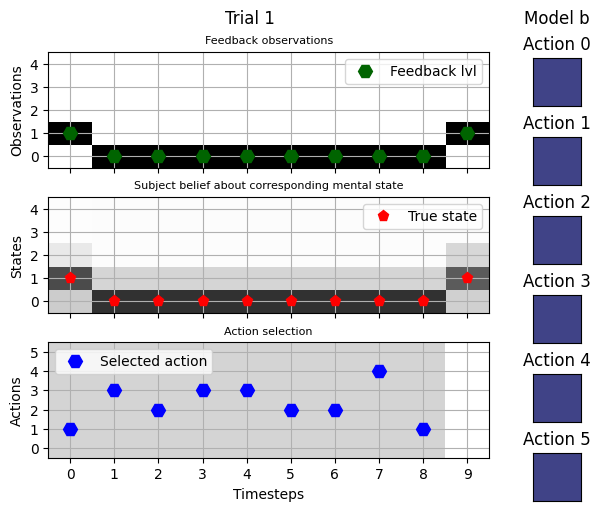

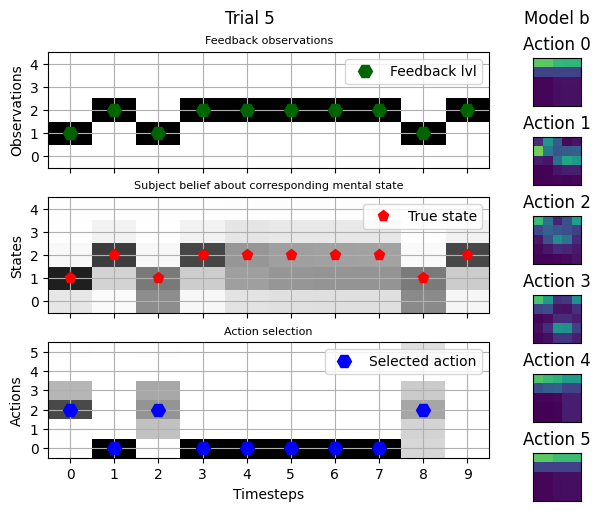

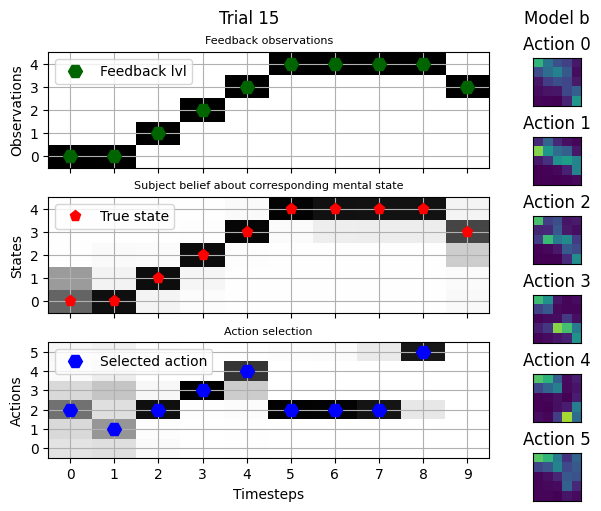

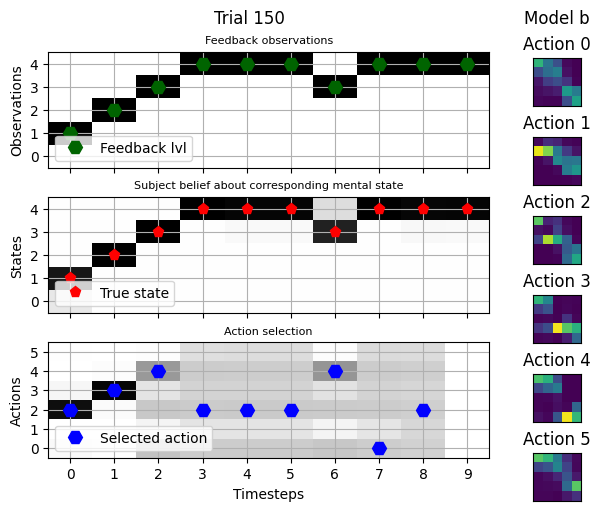

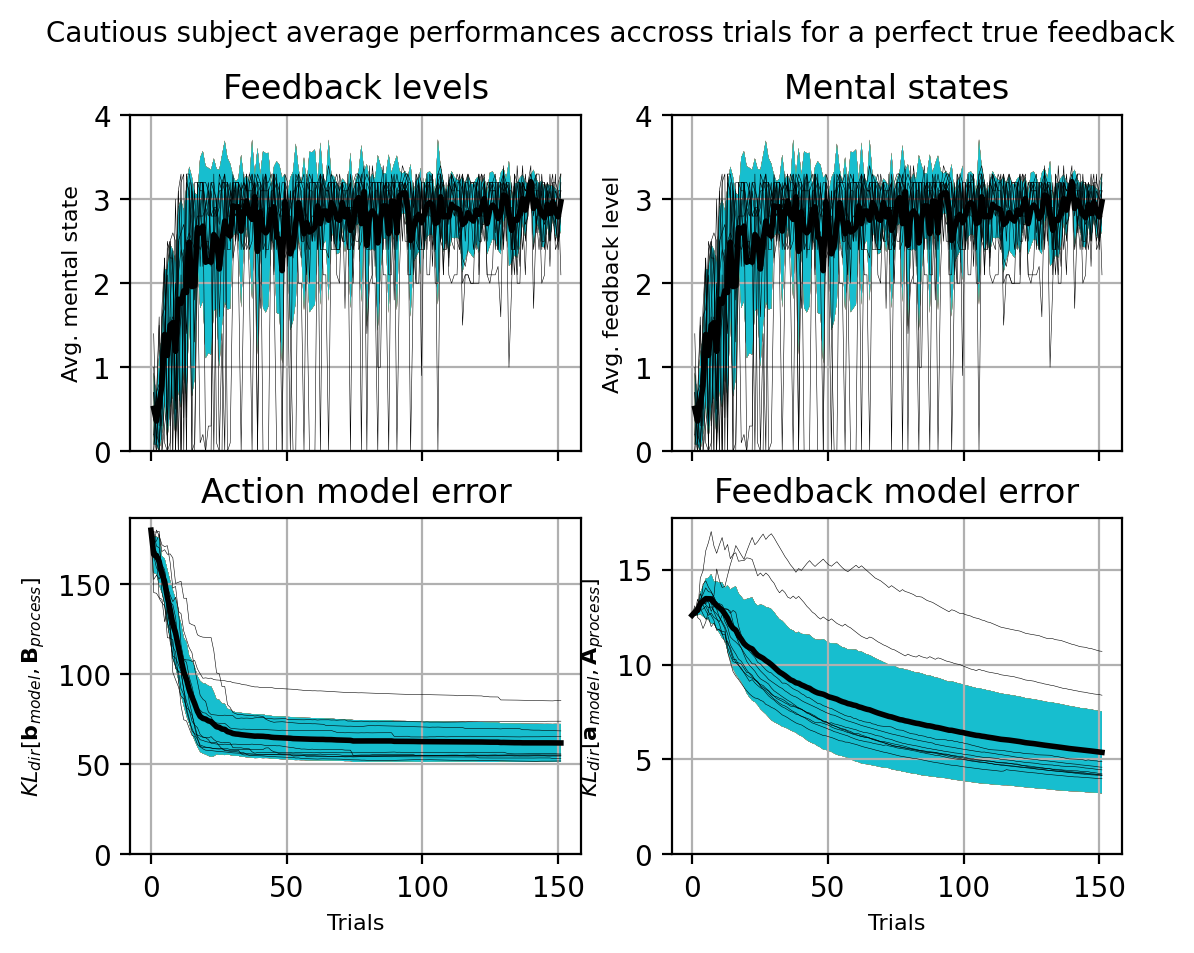

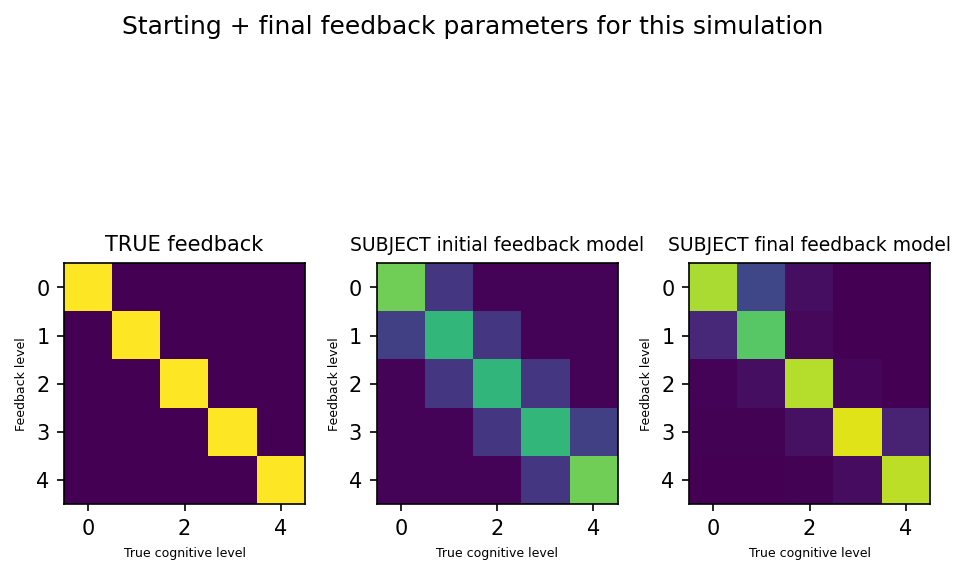

In [2]:
savepath = os.path.join(SAVING_FOLDER,"simulation1")

sigma_process = 0.01
sigma_model = 0.5
k1a = 10.0

N_subj = 10
N_trials = 150

run_and_save_model(savepath,
        sigma_process,sigma_model,k1a,
        N_subj,N_trials,
        overwrite=False)

# PLOTTING SIMULATION RESULTS
_stm,_weight,_Nsubj,_Ntrials = extract_training_data(savepath)
subject = 4 # What subject are we studying ?
plot_these_trials = [0,4,14,149]
for trial in (plot_these_trials):
    plot_one_trial(_stm,_weight,subject,trial,"Trial " + str(trial+1),
                   save_fig_path=os.path.join(FIGURES_FOLDER,"sim1"),
                   name="trial_"+str(trial)+".png")
figure = plot_training_curve(_stm,_weight,"Cautious subject average performances accross trials for a perfect true feedback",
                save_fig_path=os.path.join(FIGURES_FOLDER,"sim1"),
                name="training_curve.png")

# Plot feedback perception matrices
fig,axes = plt.subplots(1,3,dpi=150)
axes[0].imshow(actynf.normalize(_weight[0][0][0]["a"][0]),vmin=0.0,vmax=1.0)
axes[0].set_title("TRUE feedback",fontsize = 10)
axes[1].imshow(actynf.normalize(_weight[0][0][1]["a"][0]),vmin=0.0,vmax=1.0)
axes[1].set_title("SUBJECT initial feedback model",fontsize = 9)

all_end_feedback_models = np.zeros((_weight[0][0][1]["a"][0].shape)+(_Nsubj,))
for subj in range(_Nsubj) : 
    all_end_feedback_models[...,subj] = _weight[subj][-1][1]["a"][0]
axes[2].imshow(np.mean(actynf.normalize(all_end_feedback_models),axis=-1),vmin=0.0,vmax=1.0)
axes[2].set_title("SUBJECT final feedback model",fontsize = 9)

for ax in axes:
    ax.set_ylabel("Feedback level",fontsize = 6)
    ax.set_xlabel("True cognitive level",fontsize = 6)
fig.suptitle("Starting + final feedback parameters for this simulation")
fig.tight_layout()

# Save the resulting figure :
save_fig_path=os.path.join(FIGURES_FOLDER,"sim1")
name="perception_matrices.png"
if not(save_fig_path == None):
    if not os.path.exists(save_fig_path):
        os.makedirs(save_fig_path)
    fig.savefig(os.path.join(save_fig_path,name))


Observe how the error of the $\mathbf{a}$ model changes over trials in this formulation, in effect getting closer to its true value. This is lucky !

## 2. Naive subject / noisy feedback

Let's plot the same training with a noiser biomarker but a more confident subject !

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

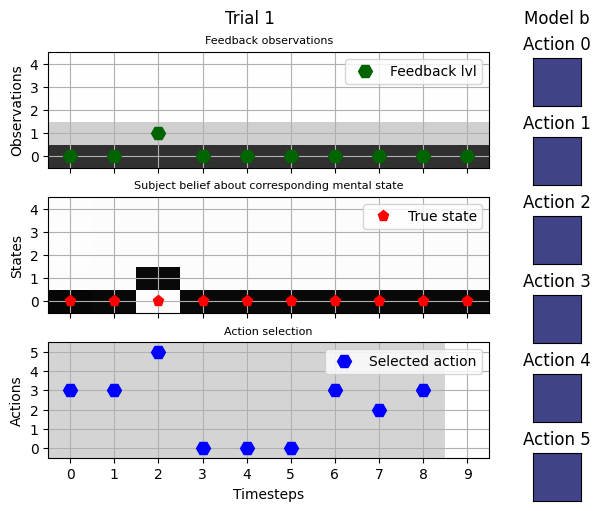

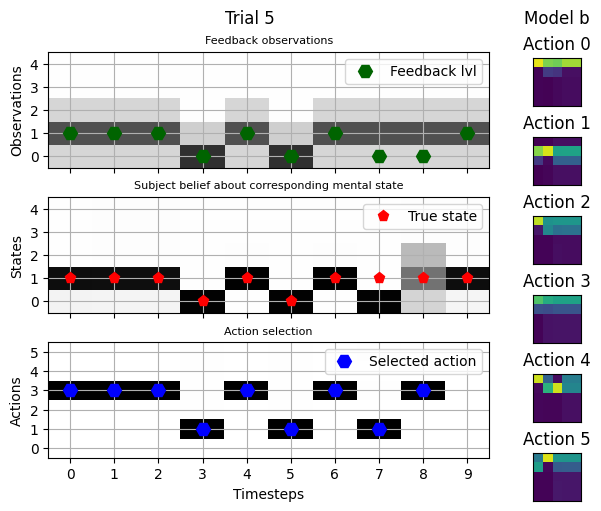

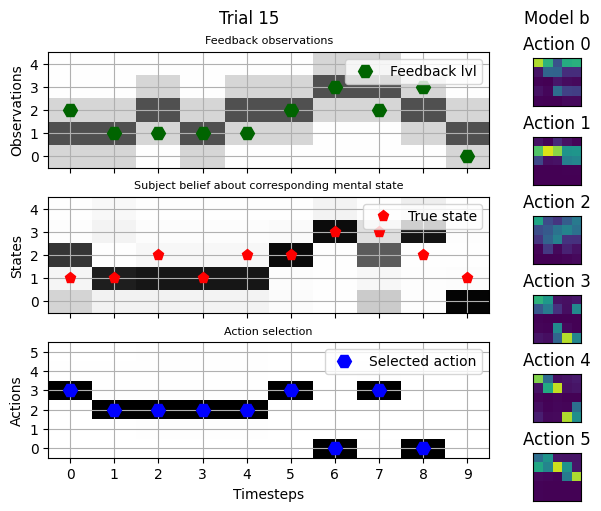

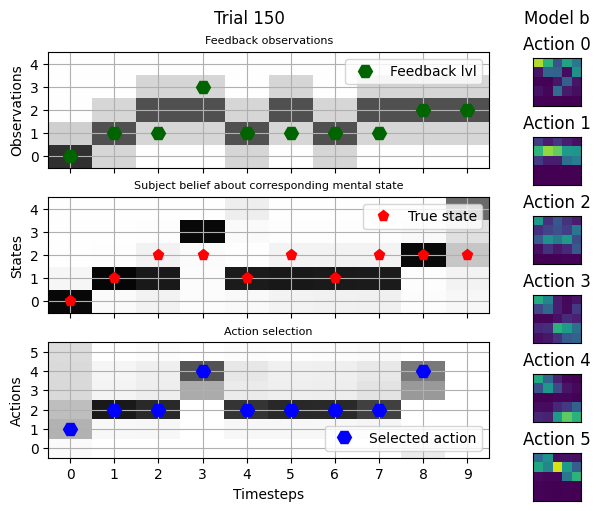

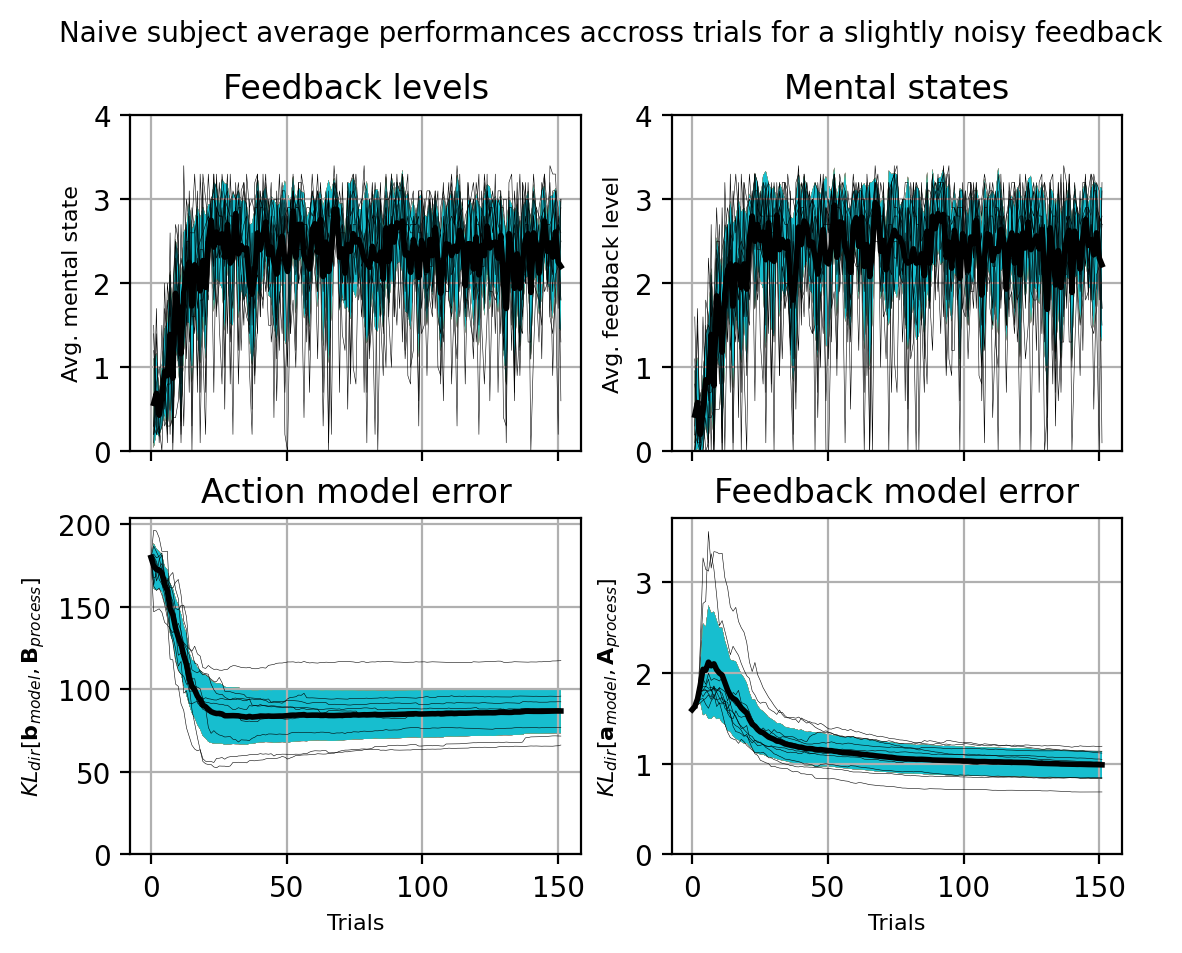

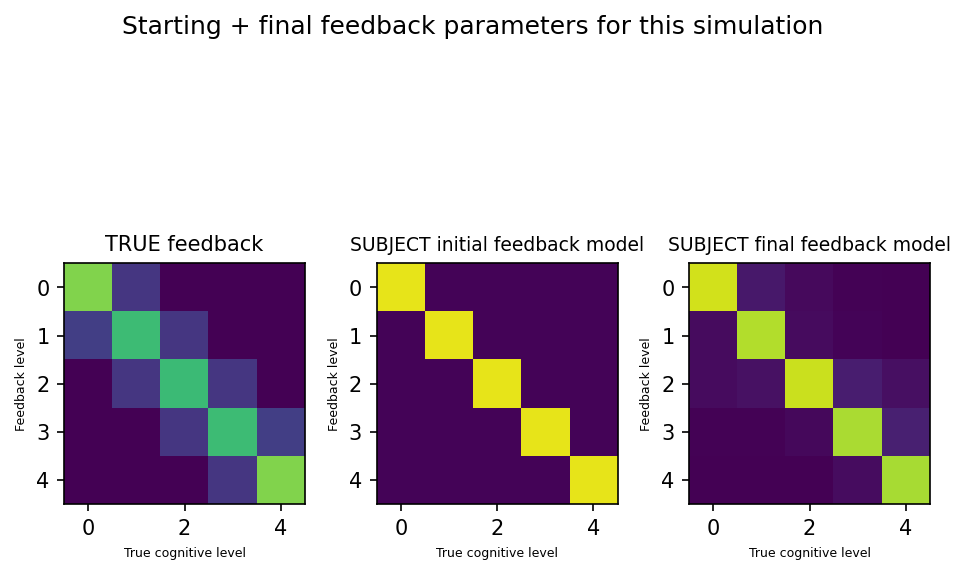

In [3]:
savepath = os.path.join(SAVING_FOLDER,"simulation2")

sigma_process = 0.5
sigma_model = 0.01
k1a = 10.0

N_subj = 10
N_trials = 150

run_and_save_model(savepath,
        sigma_process,sigma_model,k1a,
        N_subj,N_trials,
        overwrite=False)

# PLOTTING SIMULATION RESULTS
_stm,_weight,_Nsubj,_Ntrials = extract_training_data(savepath)
subject = 4 # What subject are we studying ?
plot_these_trials = [0,4,14,149]
for trial in (plot_these_trials):
    plot_one_trial(_stm,_weight,subject,trial,"Trial " + str(trial+1),
                   save_fig_path=os.path.join(FIGURES_FOLDER,"sim2"),
                   name="trial_"+str(trial)+".png")
figure = plot_training_curve(_stm,_weight,"Naive subject average performances accross trials for a slightly noisy feedback",
            save_fig_path=os.path.join(FIGURES_FOLDER,"sim2"),
            name="training_curve.png")


# Plot feedback perception matrices
fig,axes = plt.subplots(1,3,dpi=150)
axes[0].imshow(actynf.normalize(_weight[0][0][0]["a"][0]),vmin=0.0,vmax=1.0)
axes[0].set_title("TRUE feedback",fontsize = 10)
axes[1].imshow(actynf.normalize(_weight[0][0][1]["a"][0]),vmin=0.0,vmax=1.0)
axes[1].set_title("SUBJECT initial feedback model",fontsize = 9)

all_end_feedback_models = np.zeros((_weight[0][0][1]["a"][0].shape)+(_Nsubj,))
for subj in range(_Nsubj) : 
    all_end_feedback_models[...,subj] = _weight[subj][-1][1]["a"][0]
axes[2].imshow(np.mean(actynf.normalize(all_end_feedback_models),axis=-1),vmin=0.0,vmax=1.0)
axes[2].set_title("SUBJECT final feedback model",fontsize = 9)

for ax in axes:
    ax.set_ylabel("Feedback level",fontsize = 6)
    ax.set_xlabel("True cognitive level",fontsize = 6)
fig.suptitle("Starting + final feedback parameters for this simulation")
fig.tight_layout()

# Save the resulting figure :
save_fig_path=os.path.join(FIGURES_FOLDER,"sim2")
name="perception_matrices.png"
if not(save_fig_path == None):
    if not os.path.exists(save_fig_path):
        os.makedirs(save_fig_path)
    fig.savefig(os.path.join(save_fig_path,name))

## 3. Cautious subject / perfect feedback

Let's provide the subjects with a balanced situation where the feedback is noisyn, but the subject regards its observations with a little wariness.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

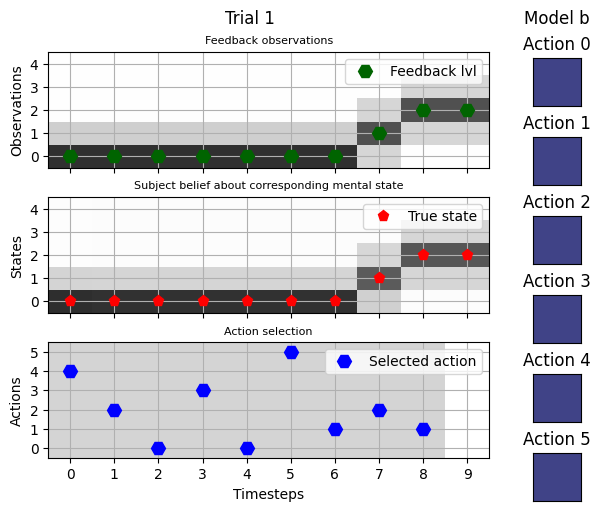

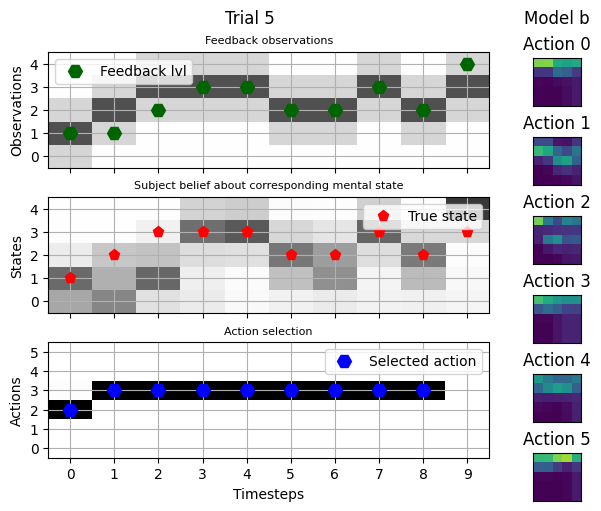

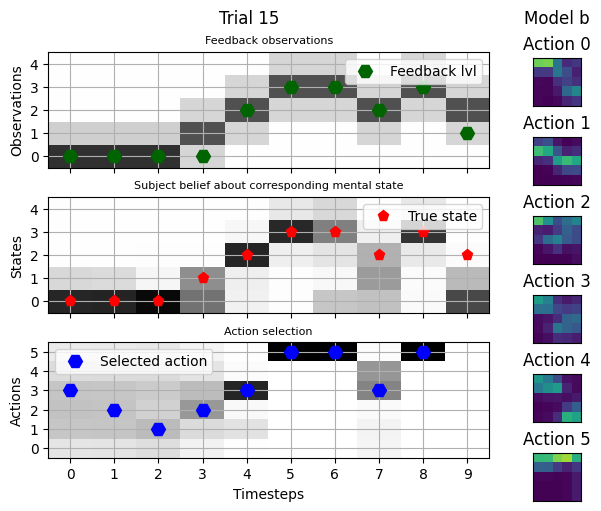

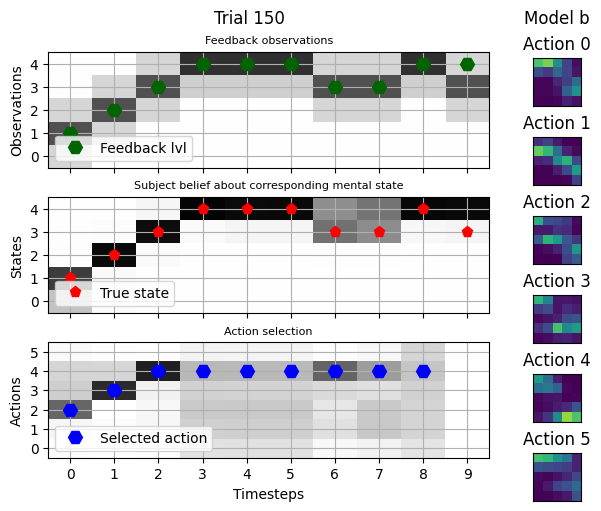

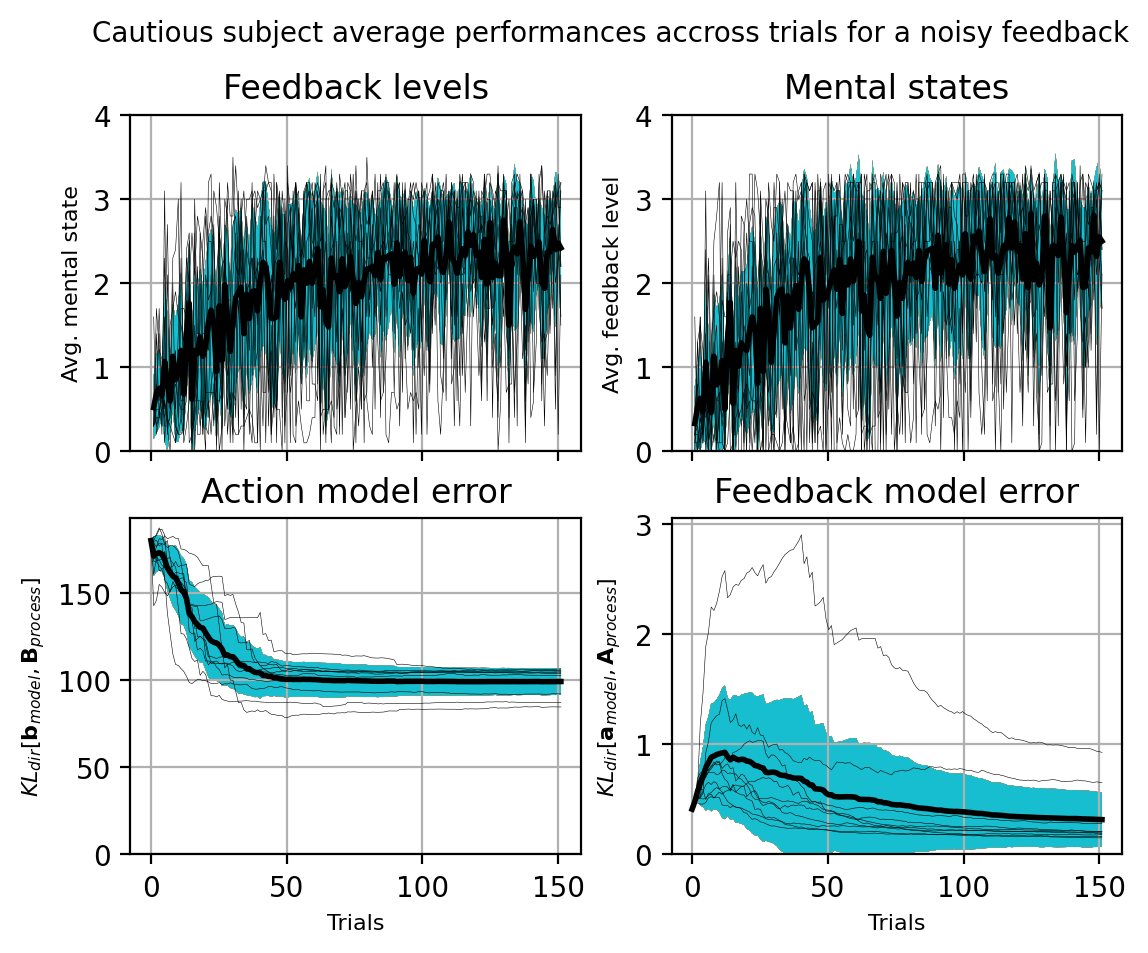

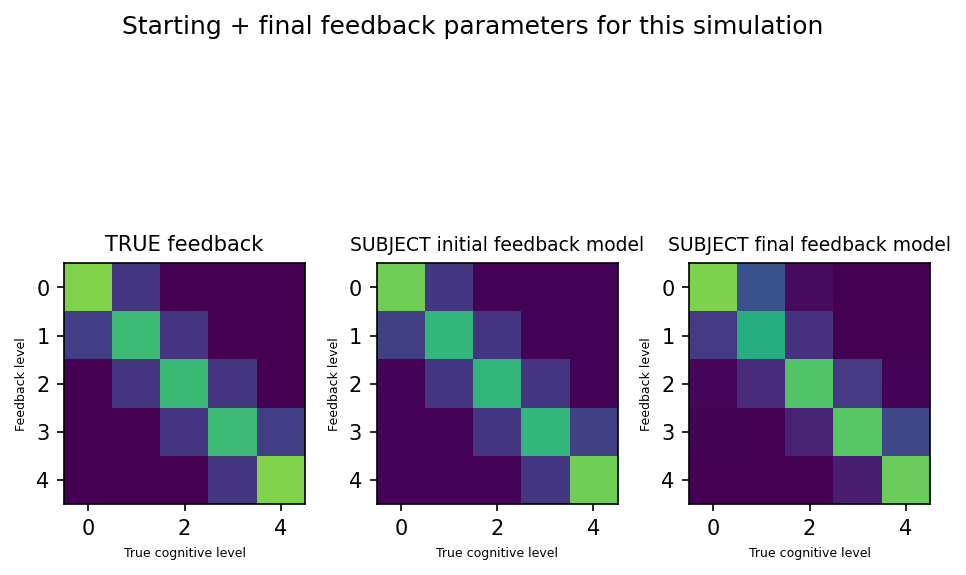

In [4]:
savepath = os.path.join(SAVING_FOLDER,"simulation3")

sigma_process = 0.5
sigma_model = 0.5
k1a = 10.0

N_subj = 10
N_trials = 150

run_and_save_model(savepath,
        sigma_process,sigma_model,k1a,
        N_subj,N_trials,
        overwrite=False)

# PLOTTING SIMULATION RESULTS
_stm,_weight,_Nsubj,_Ntrials = extract_training_data(savepath)
subject = 4 # What subject are we studying ?
plot_these_trials = [0,4,14,149]
for trial in (plot_these_trials):
    plot_one_trial(_stm,_weight,subject,trial,"Trial " + str(trial+1),
                   save_fig_path=os.path.join(FIGURES_FOLDER,"sim3"),
                   name="trial_"+str(trial)+".png")
figure = plot_training_curve(_stm,_weight,"Cautious subject average performances accross trials for a noisy feedback",
                save_fig_path=os.path.join(FIGURES_FOLDER,"sim3"),
                name="training_curve.png")


# Plot feedback perception matrices
fig,axes = plt.subplots(1,3,dpi=150)
axes[0].imshow(actynf.normalize(_weight[0][0][0]["a"][0]),vmin=0.0,vmax=1.0)
axes[0].set_title("TRUE feedback",fontsize = 10)
axes[1].imshow(actynf.normalize(_weight[0][0][1]["a"][0]),vmin=0.0,vmax=1.0)
axes[1].set_title("SUBJECT initial feedback model",fontsize = 9)

all_end_feedback_models = np.zeros((_weight[0][0][1]["a"][0].shape)+(_Nsubj,))
for subj in range(_Nsubj) : 
    all_end_feedback_models[...,subj] = _weight[subj][-1][1]["a"][0]
axes[2].imshow(np.mean(actynf.normalize(all_end_feedback_models),axis=-1),vmin=0.0,vmax=1.0)
axes[2].set_title("SUBJECT final feedback model",fontsize = 9)

for ax in axes:
    ax.set_ylabel("Feedback level",fontsize = 6)
    ax.set_xlabel("True cognitive level",fontsize = 6)
fig.suptitle("Starting + final feedback parameters for this simulation")
fig.tight_layout()

# Save the resulting figure :
save_fig_path=os.path.join(FIGURES_FOLDER,"sim3")
name="perception_matrices.png"
if not(save_fig_path == None):
    if not os.path.exists(save_fig_path):
        os.makedirs(save_fig_path)
    fig.savefig(os.path.join(save_fig_path,name))

Contrary to previous simulations, the post training performances of the subjects weren't good. Interestingly, we can observe significant changes in the subjects pereception model : Active Inference suggests that for the subjects, doubting some of their prior feedback beliefs (here: a high cognitive state is correlated with a high feedback) was *easier* than figuring out less obvious mental transitions. This leads to the observable results here : the subjects (wronglfully) began to believe that they reached high cognitive states but the feedback was still showing them low-ish values.

## 4. Performance maps for various combinations of $\sigma_{process},\sigma_{model}$

In [5]:
# Import the values we're going to plot :  
# (we ran cluster computations for k1a in [1,10] and k1a = 100)

simulation_parameters_path = os.path.join(SAVING_FOLDER,"simulation4","KEYS")
with open(simulation_parameters_path, 'rb') as handle:
        simulation_parameters = pickle.load(handle)

simulation_performances_path = os.path.join(SAVING_FOLDER,"simulation4","PERFS")
with open(simulation_performances_path, 'rb') as handle:
        simulation_performances = pickle.load(handle)

simulation_parameters_path = os.path.join(SAVING_FOLDER,"simulation5_100","KEYS")
with open(simulation_parameters_path, 'rb') as handle:
    simulation_parameters100 = pickle.load(handle)

simulation_performances_path = os.path.join(SAVING_FOLDER,"simulation5_100","PERFS")
with open(simulation_performances_path, 'rb') as handle:
    simulation_performances100 = pickle.load(handle)


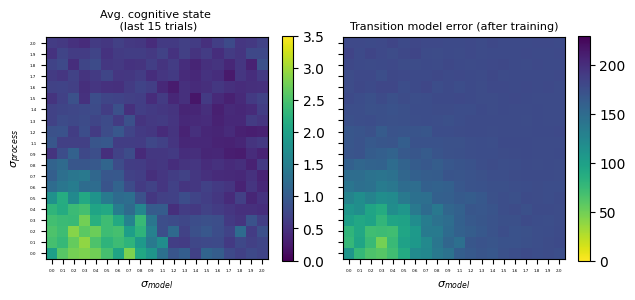

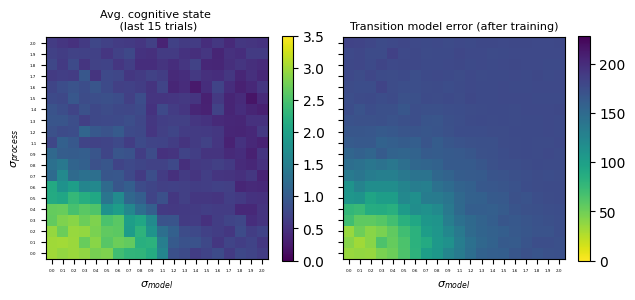

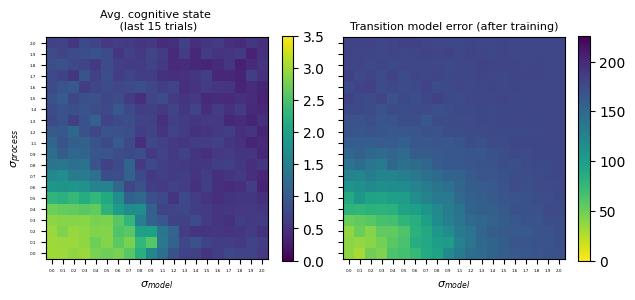

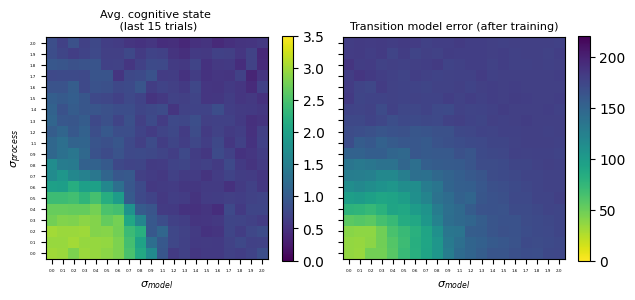

In [6]:
# 1. colormap plots !
from tools_trial_plots import colormap_plot_2D

plot_these_k1a_index_vals = [0,4,9]
for k1a in plot_these_k1a_index_vals:
        fig = colormap_plot_2D(simulation_parameters[:,:,0,:2],
                               simulation_performances['s'][:,:,k1a,:,:],
                               simulation_performances['a'][:,:,k1a,:],
                               simulation_performances['b'][:,:,k1a,:],
                title="k1a = " + str(np.round(simulation_parameters[0,0,k1a,2],1)),
                save_fig_path=os.path.join(FIGURES_FOLDER,"sim4"),name="map_k1a_"+str(k1a)+".png")
        
fig = colormap_plot_2D(simulation_parameters100,
                simulation_performances100['s'],
                simulation_performances100['a'],
                simulation_performances100['b'],
                title="k1a = " + str(np.round(simulation_parameters[0,0,k1a,2],1)),
                save_fig_path=os.path.join(FIGURES_FOLDER,"sim4"),name="map_k1a_100.png")

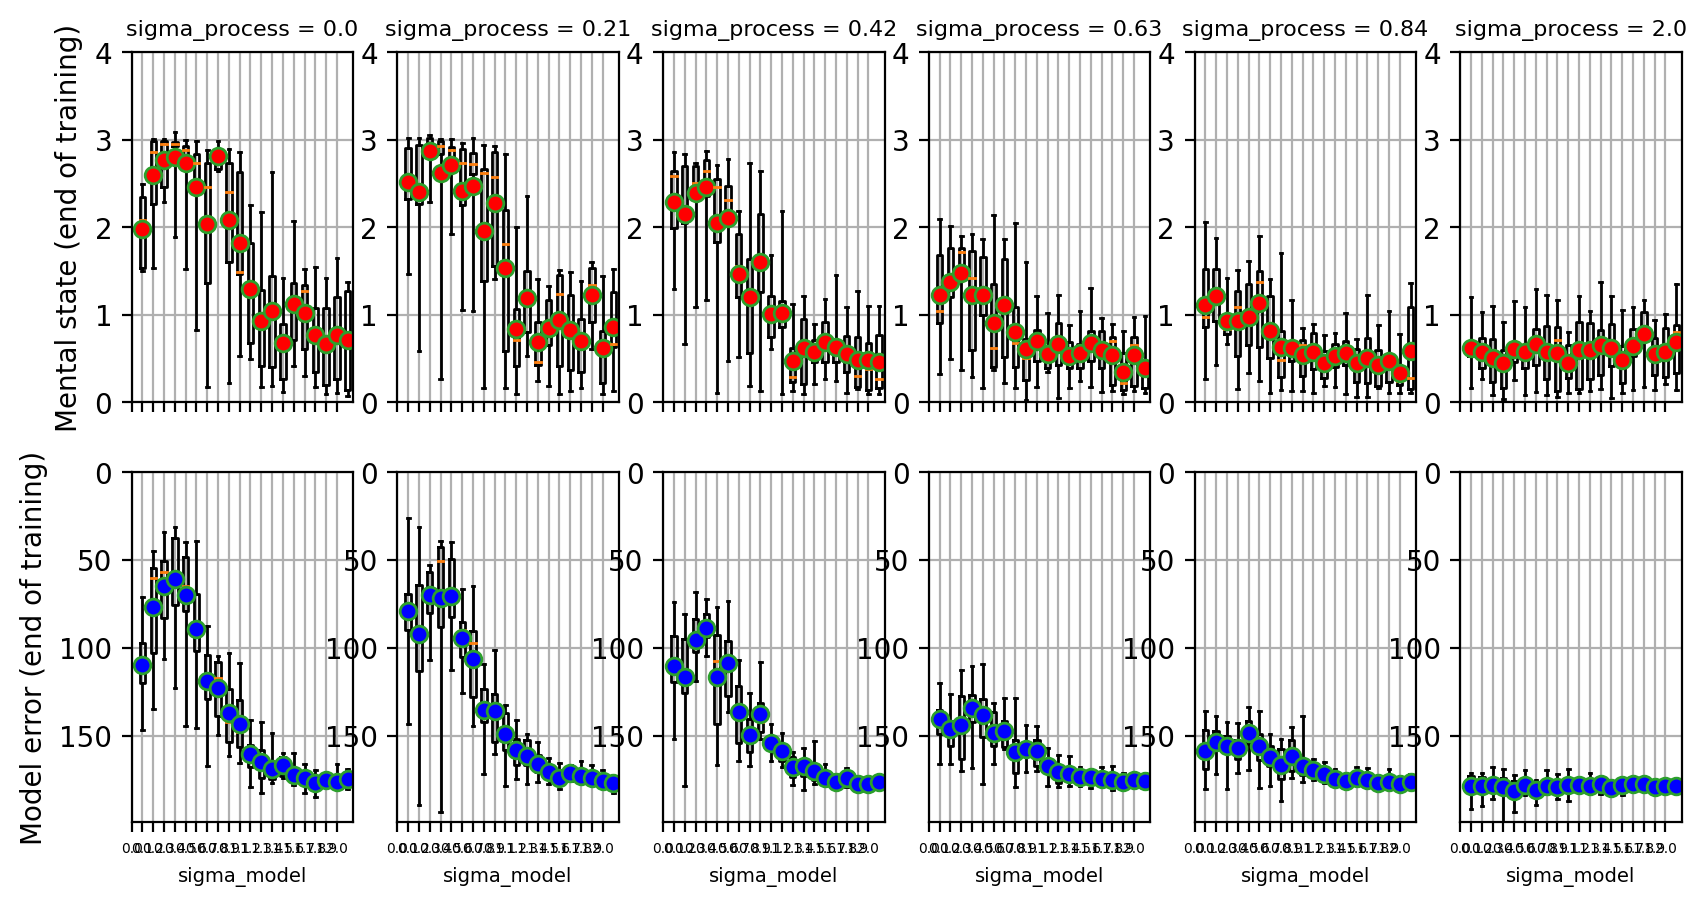

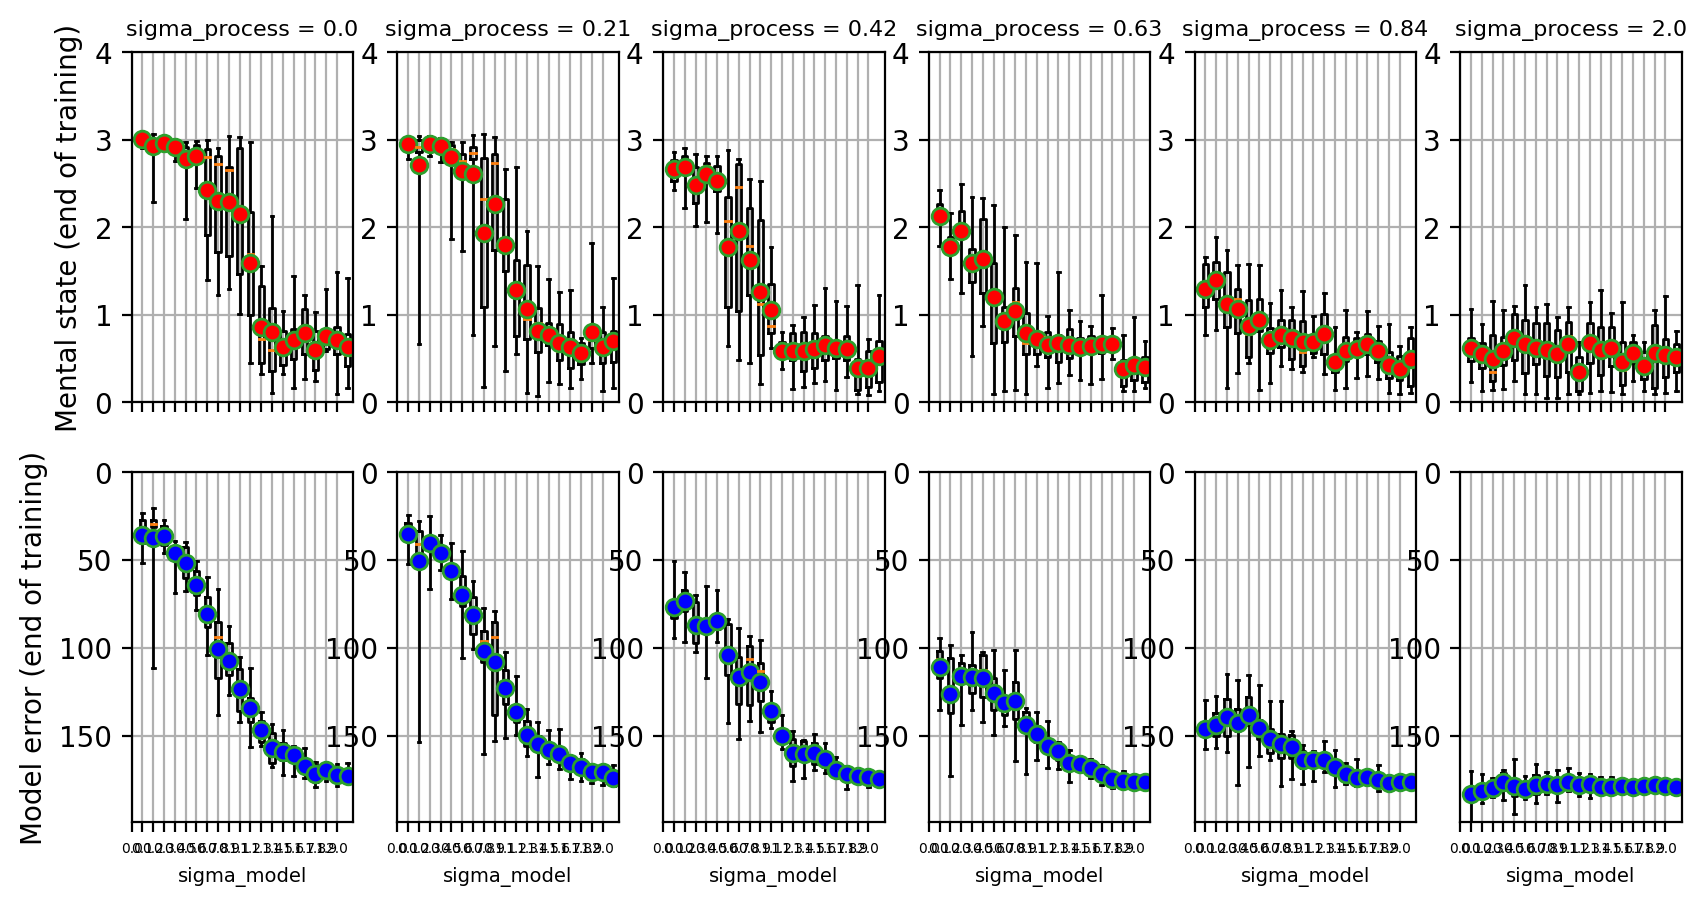

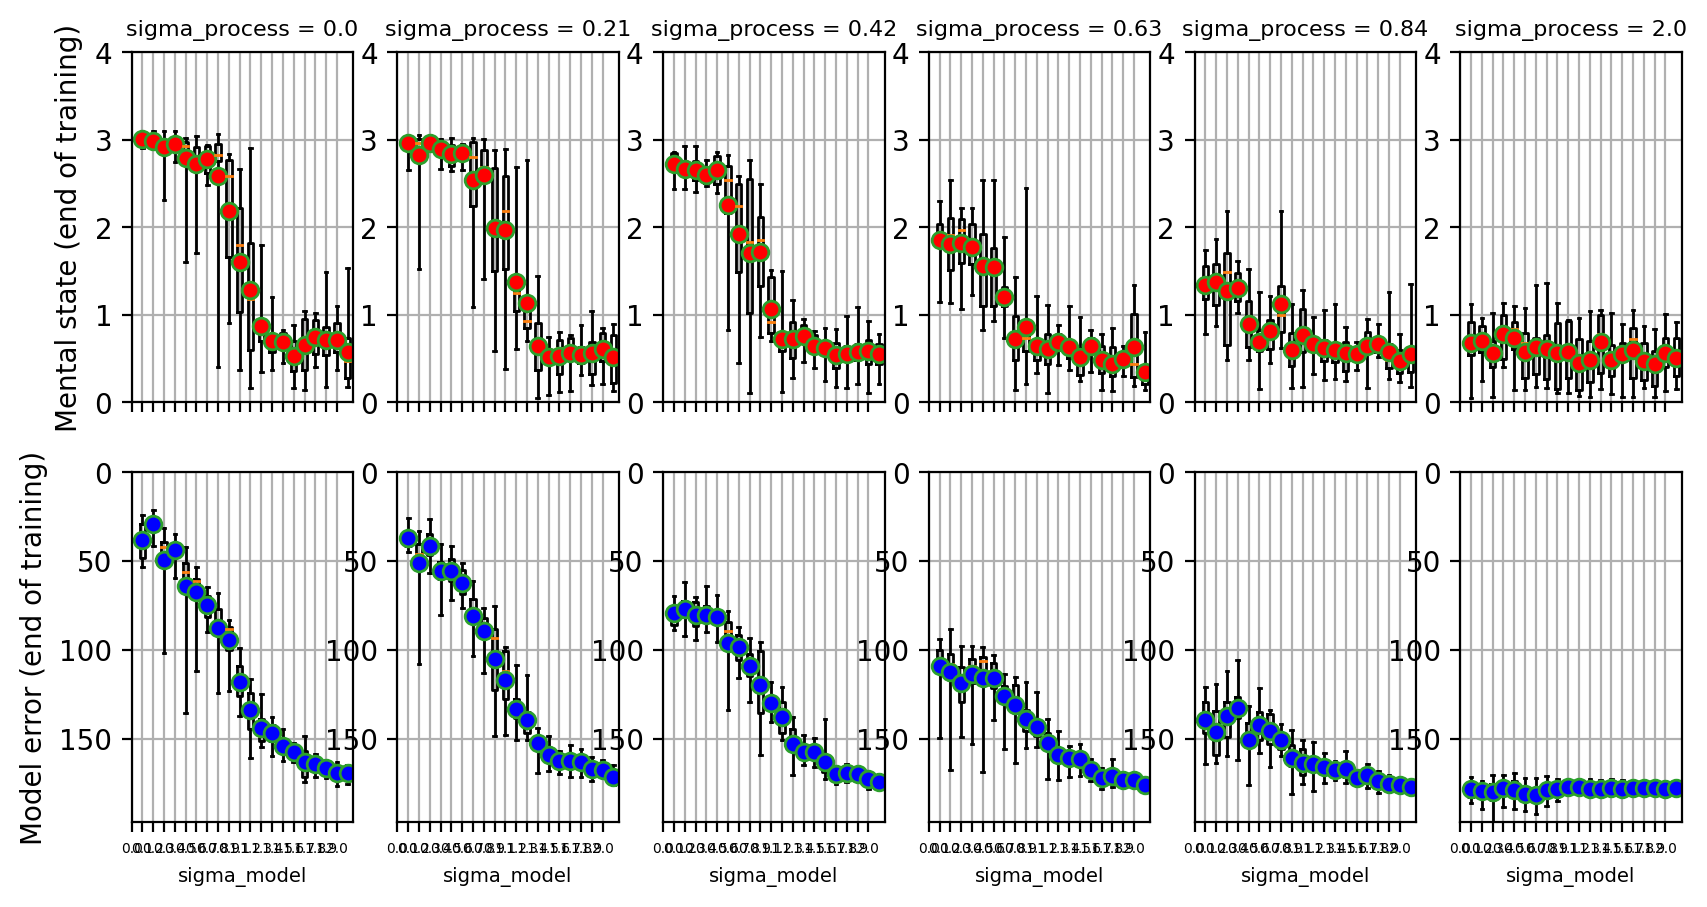

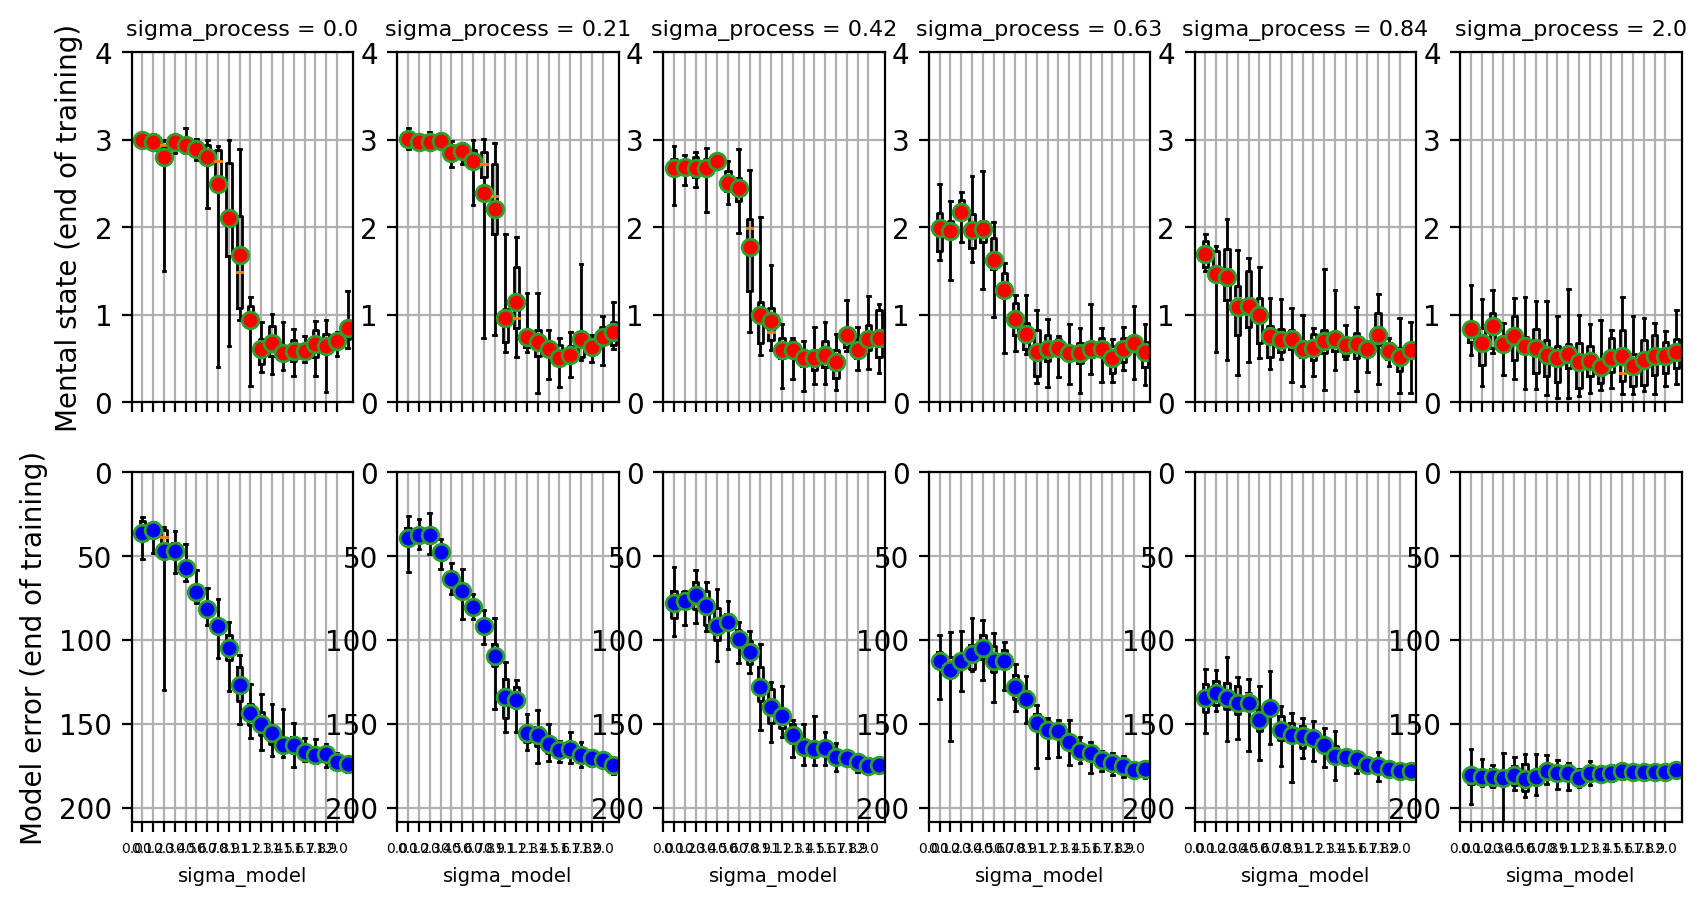

In [7]:
#2. Boxplots ! 
from tools_trial_plots import boxplot

interesting_true_fb_std_values = [0,2,4,6,8,19]

plot_these_k1a_index_vals = [0,4,9]
for k1a in plot_these_k1a_index_vals:
        fig = boxplot(simulation_parameters[:,:,0,:2],
                    simulation_performances['s'][:,:,k1a,:,:],
                    simulation_performances['a'][:,:,k1a,:],
                    simulation_performances['b'][:,:,k1a,:],
                    fixed_feedback_quality_indexes=interesting_true_fb_std_values,
                save_fig_path=os.path.join(FIGURES_FOLDER,"sim4"),name="boxplot_k1a_"+str(k1a)+".png")
        
fig = boxplot(simulation_parameters100,
                simulation_performances100['s'],
                simulation_performances100['a'],
                simulation_performances100['b'],
                fixed_feedback_quality_indexes=interesting_true_fb_std_values,
                save_fig_path=os.path.join(FIGURES_FOLDER,"sim4"),name="boxplot_k1a_100.png")

Training curves at all levels of $k1a$ were similar, indicating that the remarks made on the part 3.2.2 generalize well even when the subject doubts the feedback ! However, we can notcie a few interesting details !

First, low $k1_a$ values made the subjects initial beliefs that much more vulnerable to the noise inherent to the paradigm. It led to an overall much noiser set of performances and lower learnt model quality. An instinctive interpretation of the simulations is the following : Active Inference suggests that it's easier for the subject to question its initial feedback beliefs rather than struggling to learn complex mental actions. 

Higher $k1_a$ values subjects had very similar results to subjects not learning their feedback rules (part 3.2.2).

In both extreme cases (very volatile $k1_a=1.0$ and very confident $k1_a=100$ subject), the optimal feedback prior $\sigma_{model}$ was not $0.0$, but a value between $0.3$ and $0.5$. In intermediate conditions, the subject believing the feedback to be perfect performed better.


## 4. Last plot ! Is it better to learn or not to learn ?


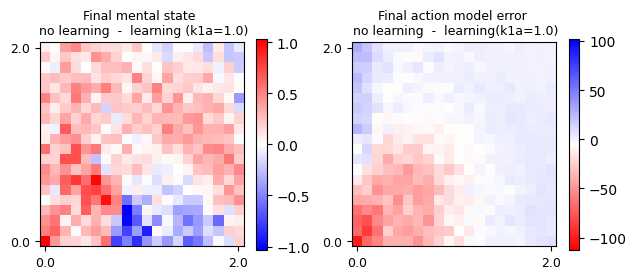

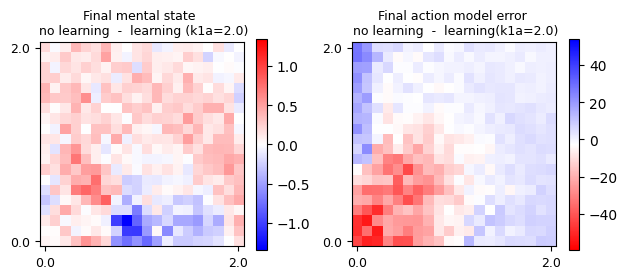

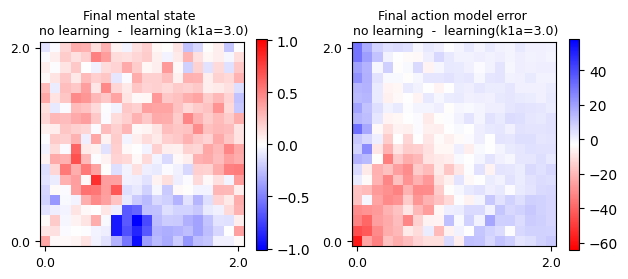

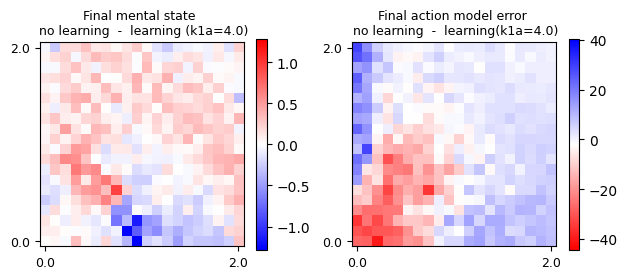

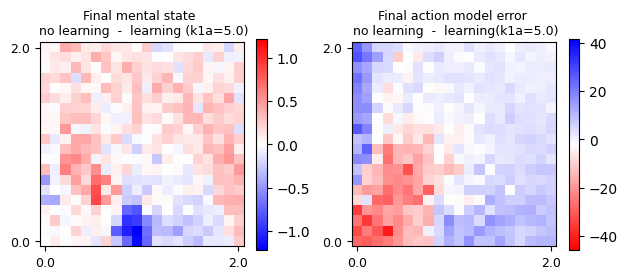

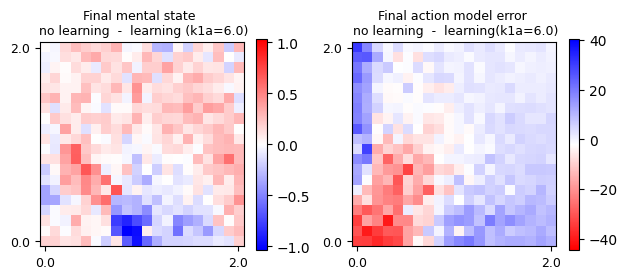

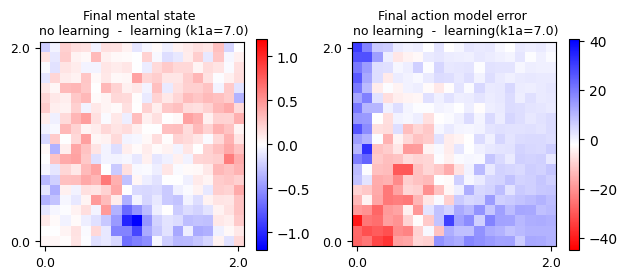

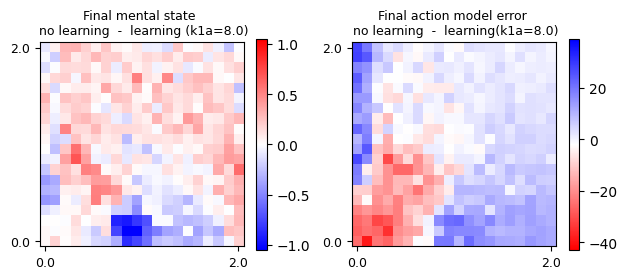

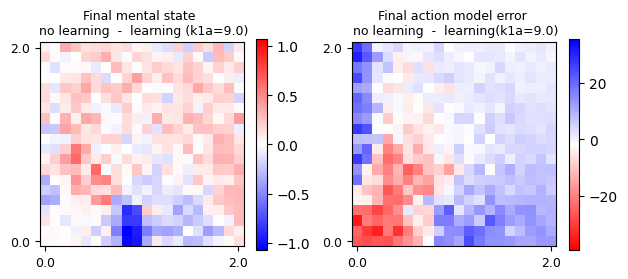

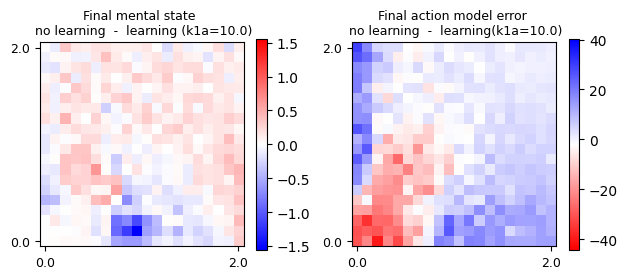

In [8]:
# Learning vs not learning the feedback mapping ! 

from tools_trial_plots import colormap_plot_2D
no_learn_folder = os.path.join("..","..","simulation_outputs","paper1","3.2.2")
simulation_parameters_path = os.path.join(no_learn_folder,"simulation3","KEYS")
with open(simulation_parameters_path, 'rb') as handle:
    simulation_parameters_no_learn = pickle.load(handle)

simulation_performances_path = os.path.join(no_learn_folder,"simulation3","PERFS")
with open(simulation_performances_path, 'rb') as handle:
    simulation_performances_no_learn = pickle.load(handle)


simulation_parameters_path = os.path.join(SAVING_FOLDER,"simulation4","KEYS")
with open(simulation_parameters_path, 'rb') as handle:
        simulation_parameters_learn = pickle.load(handle)

simulation_performances_path = os.path.join(SAVING_FOLDER,"simulation4","PERFS")
with open(simulation_performances_path, 'rb') as handle:
        simulation_performances_learn = pickle.load(handle)

for idx in range(10):
    # idx = 9
    fig,axs = plt.subplots(1,2)
    fig.tight_layout()
    lastK_trials = 15
    s_perf_dif = np.mean(simulation_performances_no_learn["s"][:,:,:,-lastK_trials:,:],axis=(-1,-2)) - np.mean(simulation_performances_learn["s"][:,:,idx,:,-lastK_trials:,:],axis=(-1,-2))
    absmax = np.max(np.abs(np.mean(s_perf_dif,axis=-1)))
    pcm = axs[0].imshow(np.mean(s_perf_dif,axis=-1),cmap="bwr",vmin=-absmax,vmax=absmax)
    axs[0].invert_yaxis()
    axs[0].set_title("Final mental state \n no learning  -  learning (k1a="+str(idx+1.0)+")",fontsize = 9)
    axs[0].set_xticks(range(0,20,19),np.round(np.linspace(0.01,2.0,2),1),fontsize=9)
    axs[0].set_yticks(range(0,20,19),np.round(np.linspace(0.01,2.0,2),1),fontsize=9)
    fig.colorbar(pcm, ax=axs[0],shrink=0.5)

    b_perf_dif = simulation_performances_no_learn["b"][:,:,:,-1] - simulation_performances_learn["b"][:,:,idx,:,-1]
    absmax = np.max(np.abs(np.mean(b_perf_dif,axis=-1)))
    pcm = axs[1].imshow(np.mean(b_perf_dif,axis=-1),cmap="bwr_r",vmax=-absmax,vmin=absmax)
    axs[1].set_title("Final action model error \n no learning  -  learning(k1a="+str(idx+1.0)+")",fontsize = 9)
    axs[1].set_xticks(range(0,20,19),np.round(np.linspace(0.01,2.0,2),1),fontsize=9)
    axs[1].set_yticks(range(0,20,19),np.round(np.linspace(0.01,2.0,2),1),fontsize=9)
    axs[1].invert_yaxis()
    fig.colorbar(pcm, ax=axs[1],shrink=0.5)

    save_fig_path=os.path.join(FIGURES_FOLDER,"sim4","diff_plot_k1a="+str(idx+1.0)+").png")
    fig.savefig(save_fig_path,bbox_inches='tight')
    

In the plots above: 
- Red meant that the results are better when the subject doesn't update its feedback model
- Blue meant that the results are better when the subject updates its feedback model

**Results :**
- In general, when the subject initial model is close to the true feedback mapping, not updating the model yields better learnt model quality. 
- Warning however, better model quality does not always mean better training ! Actions being not symmetrical, some subjects may have developped a better action mapping for the lower states but did not manage to reach upper mental states. 
- This is especially visible în the $\sigma_{model} \simeq 1.0$ and $\sigma_{process} \simeq 0.1$ cluster. In general, subjects in this cluster who changed their feedback model performed much better than non-updating subject.
- When the subject overestimates the quality of the feedback, updating their feedback model prevented overfitting and led to better action models ($\sigma_{model} \in [0.01,0.2]$ and $\sigma_{process} \in [0.5,2.0[$)
- When the subject is initially very doubtful about the feedback, updating their feedback model allowed for less noisy action models, but it only affected lower-level states.